In [43]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# ============================
# Data Preprocessing
# ============================
class AudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, downsample_rate=8000, n_fft=4096, hop_length=512, n_mels=512, max_time_frames=107, augment=True):
        self.file_list = file_list
        self.sample_rate = sample_rate
        self.downsample_rate = downsample_rate
        self.transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=downsample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.augment = augment
        self.max_time_frames = max_time_frames  # Fixed time dimension size

    def __len__(self):
        return len(self.file_list)

    def augment_waveform(self, waveform):
        spectrogram = torch.stft(
            waveform,
            n_fft=400,
            hop_length=160,
            win_length=400,
            return_complex=True
        )

        # Apply augmentations
        if torch.rand(1).item() < 0.5:
            time_stretch = torchaudio.transforms.TimeStretch(fixed_rate=1.2)
            spectrogram = time_stretch(spectrogram.unsqueeze(0)).squeeze(0)
        if torch.rand(1).item() < 0.5:
            waveform = torchaudio.transforms.PitchShift(sample_rate=self.downsample_rate, n_steps=2)(waveform)
        if torch.rand(1).item() < 0.5:
            noise = torch.randn_like(waveform) * 0.01
            waveform = waveform + noise

        # Convert spectrogram back to waveform
        if 'spectrogram' in locals():
            waveform = torch.istft(
                spectrogram,
                n_fft=400,
                hop_length=160,
                win_length=400,
            )
        return waveform

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.file_list[idx])

        # Downsample
        if sr != self.downsample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.downsample_rate)
            waveform = resampler(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Apply augmentation
        if self.augment:
            waveform = self.augment_waveform(waveform)

        # Compute Mel-Spectrogram
        mel_spectrogram = self.transform(waveform).squeeze(0)  # Shape: (n_mels, time_frames)

        # Normalize spectrogram
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-6)

        # Pad or truncate to fixed time dimension
        time_frames = mel_spectrogram.size(1)
        if time_frames < self.max_time_frames:
            # Pad with zeros
            padding = torch.zeros((mel_spectrogram.size(0), self.max_time_frames - time_frames))
            mel_spectrogram = torch.cat((mel_spectrogram, padding), dim=1)
        elif time_frames > self.max_time_frames:
            # Truncate excess frames
            mel_spectrogram = mel_spectrogram[:, :self.max_time_frames]

        return mel_spectrogram




# ============================
# Variational Autoencoder
# ============================
class VAE(nn.Module):
    def __init__(self, input_dim=(256, 107), latent_dim=64):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Flatten input dynamically
        flat_dim = input_dim[0] * input_dim[1]

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(flat_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Output mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, flat_dim),
            nn.Tanh()  # Match normalized spectrogram range [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        flat_output = self.decoder(z)
        output = flat_output.view(-1, *self.input_dim)
        return output / output.abs().max(dim=-1, keepdim=True)[0].clamp(min=1e-6)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# def vae_loss(recon_x, x, mu, logvar, beta=0.1, epsilon=1e-6):
#     # Reconstruction Loss (L1)
#     recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    
#     # KL Divergence
#     kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=epsilon))
    
#     # Weighted Loss
#     total_loss = recon_loss + beta * kl_div
#     # print(f"Reconstruction Loss: {recon_loss.item()}, KL Divergence: {kl_div.item()}, Beta: {beta}")
#     return total_loss
def vae_loss(recon_x, x, mu, logvar, beta=0.001, epsilon=1e-6):
    recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=epsilon))
    latent_regularization = torch.mean((mu.abs() - 0.5).clamp(min=0))  # Encourage usage of latent space
    return recon_loss + beta * kl_div + 0.01 * latent_regularization


# ============================
# Self-Supervised Pretraining (A-MAE)
# ============================
class MaskedAutoencoder(nn.Module):
    def __init__(self, input_dim, mask_ratio=0.8):
        super(MaskedAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.mask_ratio = mask_ratio
        self.flat_dim = input_dim[0] * input_dim[1]

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.flat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.flat_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # Randomly mask input
        mask = torch.rand(x.size()) > self.mask_ratio
        masked_x = x * mask

        # Encode and decode
        z = self.encoder(masked_x.view(masked_x.size(0), -1))
        recon_x = self.decoder(z).view(x.size())
        return recon_x, mask

def mae_loss(recon_x, x, mask, epsilon=1e-6):
    # Only calculate loss for masked regions
    valid_elements = mask.sum() + epsilon  # Avoid division by zero
    loss = F.l1_loss(recon_x * mask, x * mask, reduction='sum') / valid_elements
    return loss

# ============================
# Training Loop
# ============================
def train_model(model, dataloader, optimizer, loss_fn, epochs, device):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)

            # Handle loss based on model type
            if isinstance(model, VAE):
                recon_x, mu, logvar = output
                loss = loss_fn(recon_x, batch, mu, logvar)
            elif isinstance(model, MaskedAutoencoder):
                recon_x, mask = output
                loss = loss_fn(recon_x, batch, mask)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader.dataset):.5f}")

# ============================
# Clustering and Source Reconstruction
# ============================
def cluster_latent_representations(latent_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(latent_vectors)
    centroids = kmeans.cluster_centers_
    return clusters, centroids

def reconstruct_sources(vae, centroids, device):
    vae.eval()
    centroids = torch.tensor(centroids, dtype=torch.float32).to(device)
    with torch.no_grad():
        reconstructed_sources = vae.decode(centroids).view(-1, *vae.input_dim)
        # Denormalize reconstructed spectrograms
        reconstructed_sources = (reconstructed_sources + 1) / 2  # Scale back to [0, 1]
    return reconstructed_sources


# ============================
# Example Usage
# ============================
if __name__ == "__main__":
    # Parameters
    # Define the folder containing the audio files
    folder_path = "ground_truth_others"

    # Get a list of all .wav files in the folder
    file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]

    dataset = AudioDataset(file_list)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Adjust dataset initialization
    sample_data = next(iter(dataloader))  # Load a single batch
    input_dim = sample_data[0].shape[-2:]  # (n_mels, time_frames)

    # Pretrain with A-MAE
    mae = MaskedAutoencoder(input_dim=input_dim)
    mae_optimizer = torch.optim.Adam(mae.parameters(), lr=1e-5)
    train_model(mae, dataloader, mae_optimizer, mae_loss, epochs=10, device=device)

    # Train VAE
    vae = VAE(input_dim=input_dim, latent_dim=64)
    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)
    train_model(vae, dataloader, vae_optimizer, vae_loss, epochs=10, device=device)

    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Apply weight initialization
    mae.apply(init_weights)
    vae.apply(init_weights)


    # Extract Latent Representations
    latent_vectors = []
    for batch in dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            mu, _ = vae.encode(batch.view(batch.size(0), -1))
            mu = mu.cpu().numpy()
            mu = np.nan_to_num(mu, nan=0.0)  # Replace NaN values with 0
            latent_vectors.append(mu)
    latent_vectors = np.concatenate(latent_vectors)


    for batch in dataloader:
        batch = batch.to(device)
        mu, logvar = vae.encode(batch.view(batch.size(0), -1))
        plt.hist(mu.cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='mu')
        plt.hist(torch.exp(0.5 * logvar).cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='std')
        plt.legend()
        plt.show()
        break


    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(batch[0].cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.title("Reconstructed")
            plt.imshow(recon[0].cpu().numpy())
            plt.show()
            break

    with torch.no_grad():
        mu, _ = vae.encode(batch.view(batch.size(0), -1))
        recon = vae.decode(mu).cpu()
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(batch[0].cpu().numpy())
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed")
        plt.imshow(recon[0].cpu().numpy())
        plt.show()

    for _ in range(3):
        random_latent = torch.randn(1, vae.latent_dim).to(device)
        recon = vae.decode(random_latent).cpu()
        plt.imshow(recon[0].detach().numpy())
        plt.title("Random Latent Vector Decoded Output")
        plt.show()

    with torch.no_grad():
        recon = vae.decode(mu).cpu()
        diff = (batch[0].cpu().numpy() - recon[0].cpu().numpy())
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(batch[0].cpu().numpy())
        plt.subplot(1, 3, 2)
        plt.title("Reconstructed")
        plt.imshow(recon[0].cpu().numpy())
        plt.subplot(1, 3, 3)
        plt.title("Difference")
        plt.imshow(diff)
        plt.show()



    assert not np.any(np.isnan(latent_vectors)), "NaN values found in latent vectors after imputation."
    assert latent_vectors.shape[1] > 0, "Latent vectors have no features for clustering."

    # Clustering and Reconstruction
    num_clusters = 2  # Example: Separate into 2 sources
    clusters, centroids = cluster_latent_representations(latent_vectors, num_clusters)
    reconstructed_sources = reconstruct_sources(vae, centroids, device=device)

    # Save reconstructed sources as audio files
    for i, source in enumerate(reconstructed_sources): 
        # Ensure proper shape for mono audio
        if source.dim() == 2:  # Shape is (channels, time)
            source = source.mean(dim=0, keepdim=True)  # Convert to mono

        # Denormalize back to [-1, 1] range for audio playback
        source = source * 2 - 1

        # Calculate required number of samples
        required_samples = 8000 * 6  # 6 seconds at 8000 Hz

        # Adjust the length
        current_samples = source.size(1)
        if current_samples < required_samples:
            # Pad with zeros
            padding = torch.zeros((1, required_samples - current_samples), dtype=source.dtype)
            source = torch.cat((source, padding), dim=1)
        elif current_samples > required_samples:
            # Truncate to required length
            source = source[:, :required_samples]

        # Normalize waveform to [-1, 1]
        source = source / source.abs().max()

        # Convert to 16-bit integer format
        source = torch.clamp(source * 32767, -32768, 32767).to(torch.int16)

        # Save the audio file
        output_path = f"source_{i}.wav"
        try:
            torchaudio.save(output_path, source.cpu(), sample_rate=8000)
            print(f"Saved: {output_path}")
        except Exception as e:
            print(f"Error saving {output_path}: {e}")


Epoch 1, Loss: 0.0150
Epoch 2, Loss: 0.0149
Epoch 3, Loss: 0.0149
Epoch 4, Loss: 0.0146
Epoch 5, Loss: 0.0146
Epoch 6, Loss: 0.0146


KeyboardInterrupt: 

In [25]:
float_source = source.to(torch.float32)  # Convert to float for computations
print(f"Source min: {float_source.min().item()}, max: {float_source.max().item()}")
print(f"Source mean: {float_source.mean().item()}, std: {float_source.std().item()}")


Source min: 0.0, max: 32767.0
Source mean: 73.03771209716797, std: 1545.239501953125


In [4]:
print(sample_data.shape)  # Shape of a batch of data from the DataLoader


torch.Size([16, 256, 107])


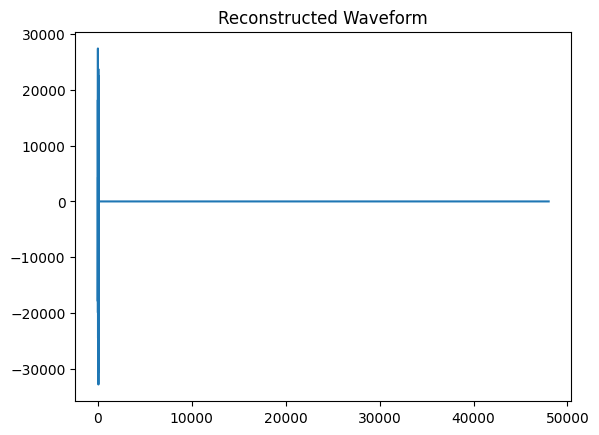

In [36]:
import matplotlib.pyplot as plt

plt.plot(source.squeeze().cpu().numpy())
plt.title("Reconstructed Waveform")
plt.show()


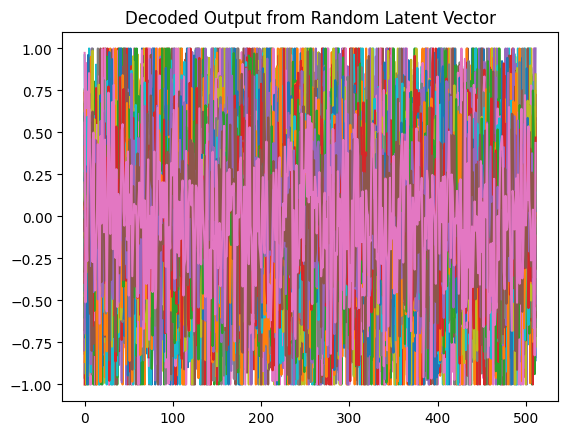

In [37]:
random_latent = torch.randn(1, vae.latent_dim).to(device)
output = vae.decode(random_latent).cpu()
plt.plot(output.squeeze().detach().numpy())
plt.title("Decoded Output from Random Latent Vector")
plt.show()
